# 프로젝트 - Movielens 영화 추천 실습
- 이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

- 이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 **Movielens 데이터**입니다.
<br>
- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
  - 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 **implicit 데이터로 간주**하고 테스트해 볼 수 있습니다.
  - **별점을 시청횟수로 해석**해서 생각하겠습니다.
  - 또한 유저가 **3점 미만으로 준 데이터는 선호하지 않는다**고 가정하고 제외하겠습니다.<br>
<br>
- Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다.
- Cloud shell에서 아래 명령어를 입력해 주세요.

- \$ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
- \$ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m

### 1) 데이터 준비와 전처리
- Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [1]:
import pandas as pd
import os

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [4]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


- 여기까지가 전처리입니다. 이후에는 이전 스텝에 소개했던 것과 동일한 방식으로 MF model을 구성하여 내가 좋아할 만한 영화를 추천해 볼 수 있습니다.

In [5]:
movies.loc[1175:1177]

,movie_id,title,genre
1175,1192,Paris Is Burning (1990),Documentary
1176,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1177,1194,Up in Smoke (1978),Comedy


<span style = "color:blue; font-weight:bold;  font-size:25px">[[ your code 시작]]</span>

- 영화 제목 확인을 위해 데이터프레임 ratings와 movies를 합침
  - pd.merge(): 두 데이터의 공통 열이름(movie_id)을 기준으로 inner(교집합) 조인

In [6]:
data = pd.merge(ratings, movies)

In [7]:
# merge한 데이터 확인
data.head(3)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama


In [8]:
data.columns # 컬럼명 확인

Index(['user_id', 'movie_id', 'counts', 'timestamp', 'title', 'genre'], dtype='object')

- 사용할 컬럼만 남기고 제거

In [9]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'title', 'counts']
data = data[using_cols]
data.head(3)

,user_id,title,counts
0,1,One Flew Over the Cuckoo's Nest (1975),5
1,2,One Flew Over the Cuckoo's Nest (1975),5
2,12,One Flew Over the Cuckoo's Nest (1975),4


- 검색을 쉽게 하기 위해 title 문자열을 소문자로 바꿈

In [10]:
data['title'] = data['title'].str.lower() # 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data.head(3)

,user_id,title,counts
0,1,one flew over the cuckoo's nest (1975),5
1,2,one flew over the cuckoo's nest (1975),5
2,12,one flew over the cuckoo's nest (1975),4


- 첫 번째 유저가 어떤 영화를 보는 지 확인
  - <span style="color:blue">[코드 확인] 행 조회: data.loc[행]; 열 조회: data.loc[행, 열]</span>
  - 첫 번째 유저의 user_id = data.loc[0, 'user_id'])

In [11]:
condition = (data['user_id'] == data.loc[0, 'user_id'])
data.loc[condition]

,user_id,title,counts
0,1,one flew over the cuckoo's nest (1975),5
1680,1,james and the giant peach (1996),3
2123,1,my fair lady (1964),3
2734,1,erin brockovich (2000),4
3957,1,"bug's life, a (1998)",5
5556,1,"princess bride, the (1987)",3
7808,1,ben-hur (1959),5
8474,1,"christmas story, a (1983)",5
9764,1,snow white and the seven dwarfs (1937),4
10471,1,"wizard of oz, the (1939)",4


- 다양한 영화들이 보임... 벤허, 죽은시인의 사회, 레인맨...

- **<span style="color:blue">내가 좋아하는 영화 찾기</span>**

In [12]:
select = data.query('title.str.contains("few good")') ## df.query(조건식 문자열)
select.head(1)

,user_id,title,counts
60339,2,"few good men, a (1992)",5


In [13]:
select = data.query('title.str.contains("top gun")') ## df.query(조건식 문자열)
select.head(1)

,user_id,title,counts
264335,6,top gun (1986),4


In [14]:
select = data.query('title.str.contains("mission")') ## df.query(조건식 문자열)
select.head(1)

,user_id,title,counts
59058,2,mission: impossible (1996),4


In [15]:
select = data.query('title.str.contains("rain")') ## df.query(조건식 문자열)
select.head(1)

,user_id,title,counts
40620,1,rain man (1988),5


In [16]:
select = data.query('title.str.contains("crimson")') ## df.query(조건식 문자열)
select.head(1)

,user_id,title,counts
304671,8,crimson tide (1995),3


### 2) 분석해 봅시다.
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [17]:
# 유니크한 영화 개수
data['title'].nunique()

3628

In [18]:
# 유니크한 사용자(유저) 수
data['user_id'].nunique()

6039

- <span style="color:blue">[코드 설명] data['user-id']를 'title'별로 집계한 후 숫자(count())를 구해라</span>
  - 각 영화는 몇 명의 유저를 가지고 있는가...의 의미 (중복 허용)

In [19]:
# 가장 인기 있는 영화 30개(인기순)
movie_count = data.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
american beauty (1999)                                   3211
star wars: episode iv - a new hope (1977)                2910
star wars: episode v - the empire strikes back (1980)    2885
star wars: episode vi - return of the jedi (1983)        2716
saving private ryan (1998)                               2561
terminator 2: judgment day (1991)                        2509
silence of the lambs, the (1991)                         2498
raiders of the lost ark (1981)                           2473
back to the future (1985)                                2460
matrix, the (1999)                                       2434
jurassic park (1993)                                     2413
sixth sense, the (1999)                                  2385
fargo (1996)                                             2371
braveheart (1995)                                        2314
men in black (1997)                                      2297
schindler's list (1993)                                  2257
pr

- <span style="color:blue">[코드 설명] data['title']을 'user-id'별로 집계한 후 숫자(count())를 구해라</span>
  - 각 유저는 몇 편의 영화를 보는가? ...의 의미

In [20]:
# 유저별 몇 편의 영화를 보고 있는 지에 대한 통계
user_count = data.groupby('user_id')['title'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: title, dtype: float64

### 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.
- 미션 임파서블, 어퓨굿맨, 크림슨타이드, 탑건, 쇼생크탈출 추가

In [21]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['mission: impossible (1996)', 'few good men, a (1992)', 'crimson tide (1995)', 'top gun (1986)', 'shawshank redemption, the (1994)']
# 'me'이라는 user_id가 위 영화에 평점 5점으로 가정
my_playlist = pd.DataFrame({'user_id': ['me']*5, 'title': my_favorite, 'counts':[5]*5})

if not data.isin({'user_id':['me']})['user_id'].any():  # user_id에 'me'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,title,counts
836473,5851,one little indian (1973),5
836474,5854,slaughterhouse (1987),4
836475,5854,"promise, the (versprechen, das) (1994)",3
836476,5938,"five wives, three secretaries and me (1998)",4
836477,5948,identification of a woman (identificazione di ...,5
0,me,mission: impossible (1996),5
1,me,"few good men, a (1992)",5
2,me,crimson tide (1995),5
3,me,top gun (1986),5
4,me,"shawshank redemption, the (1994)",5


### + 모델에 활용하기 위한 전처리
- **user와 movie(title) 각각에 번호 붙이기** 

In [22]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()

# 유저, 영화 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [23]:
# 인덱싱이 잘 되었는지 확인
print("me: ", user_to_idx['me'])    # 6040명의 유저 중 마지막으로 추가된 유저이니 6039가 나와야 함 
print("paris is burning: ", movie_to_idx['paris is burning (1990)'])
print("a few good men: ", movie_to_idx['few good men, a (1992)'])

me:  6039
paris is burning:  234
a few good men:  59


- <span style="color:blue">[코드 설명] df.map함수는 Series의 값 하나하나에 접근하면서 해당 함수를 수행</span>

In [24]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
print(len(temp_user_data))
print(len(data))
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 movie(title) 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = data['title'].map(movie_to_idx.get).dropna()
print(len(temp_user_data))
print(len(data))
if len(temp_movie_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

data

836483
836483
user_id column indexing OK!!
836483
836483
title column indexing OK!!


,user_id,title,counts
0,0,0,5
1,1,0,5
2,2,0,4
3,3,0,4
4,4,0,5
...,...,...,...
0,6039,58,5
1,6039,59,5
2,6039,407,5
3,6039,326,5


- data의 user_id와 title 컬럼 값들이 모두 정수 인덱스 값으로 잘 변경 
- 훈련을 위한 전처리 완료!

### 4) CSR matrix를 직접 만들어 봅시다.

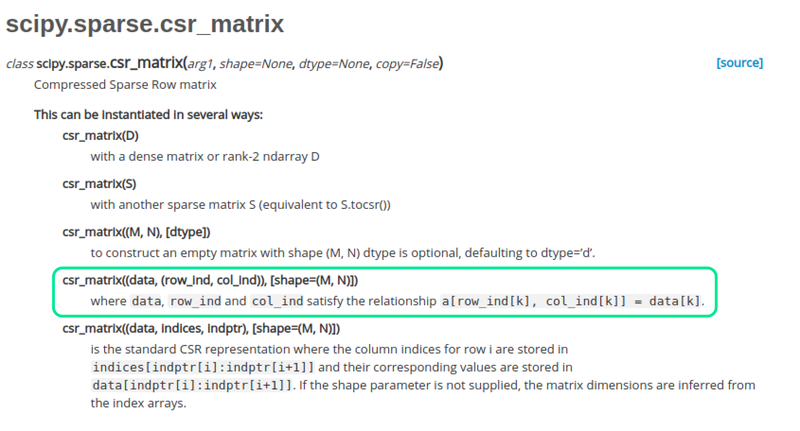

In [25]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_movie = data['title'].nunique()

csr_data = csr_matrix((data.counts, (data.user_id, data.title)), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

### 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [26]:
from implicit.als import AlternatingLeastSquares
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

- AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

  1. factors: 유저와 아이템의 벡터를 몇 차원으로 할 것인지
  2. regularization: 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
  3. use_gpu: GPU를 사용할 것인지
  4. iterations: epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지  
     - 1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

- <span style="color:blue">[**코드 설명**] 유저와 영화(아이템) 벡터를 100차원으로 지정. 즉, k = 100</span>
  - <span style="color:blue">유저(6040). 영화(3628)</span>
  - <span style="color:blue">유저 x 영화 평가행렬 = 6040 x 3628 ... Sparse matrix이므로 CSR(Compressed Sparse Row) martix로 저장</span>
  - <span style="color:blue">MF(Martix Factorization)를 사용해서 (6040 x 3628) = (6040 x 100) x (100 x 3628) = User x Item (movie) = U$_i$ x I$_j$ 로 표현</span>
  - <span style="color:blue">U$_i$와 I$_j$를 구하기 위해서 implicit 패키지의 als (Alternating Least Suares) 모델 사용</span>

In [27]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [28]:
# Implicit AlternatingLeastSquares 모델의 선언

# factors = 100으로 고정하고 최적 iterations값 찾기

factors = 100
#als_model = AlternatingLeastSquares(factors, regularization=0.01, use_gpu=False, iterations=10, dtype=np.float32)
#als_model = AlternatingLeastSquares(factors, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
als_model = AlternatingLeastSquares(factors, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)
#als_model = AlternatingLeastSquares(factors, regularization=0.01, use_gpu=False, iterations=30, dtype=np.float32)


In [29]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

### 모델 학습 종료! 다음 두 가지 사항 확인:

  1. me 벡터와 few good men, a (1992) 벡터를 어떻게 만들고 있는지
  2. 두 벡터를 곱하면 어떤 값이 나오는지

In [30]:
me, goodmen = user_to_idx['me'], movie_to_idx['few good men, a (1992)']
me_vector, goodmen_vector = als_model.user_factors[me], als_model.item_factors[goodmen]

print('슝=3')

슝=3


- <span style="color:blue">[**코드 설명**] 유저행렬(U$_i$)과 아이템(영화)행렬(I$_j$)을 구했음</span>
- <span style="color:blue">U$_{me}$과 I$_{goodmen}$를 가지고 선호도(Rating)를 확인해 보자. '1'이 나와야 함</span>


In [31]:
me_vector

array([-4.16171283e-01,  7.32810259e-01,  3.85676414e-01,  4.36218917e-01,
       -6.07329071e-01, -1.25831559e-01, -2.27230906e-01, -1.77314892e-01,
       -4.30385649e-01, -8.23692232e-02, -6.46309018e-01, -8.71922299e-02,
       -3.74217212e-01, -7.65475869e-01,  1.24012426e-01, -2.35222466e-03,
        3.05836052e-01,  3.49976391e-01,  5.10406733e-01, -5.68129420e-01,
        3.30959167e-03,  1.66886270e-01, -6.80783808e-01,  4.48964566e-01,
       -2.25469023e-01,  2.66048908e-01, -3.06143820e-01,  2.86899775e-01,
       -7.95519128e-02, -2.59681135e-01, -9.89983510e-03,  4.74856138e-01,
       -1.97970659e-01,  2.92923093e-01,  5.88296235e-01, -6.08879983e-01,
       -5.05068004e-01, -4.77063328e-01,  1.08677912e+00, -3.56332660e-01,
       -3.04982930e-01,  1.03343785e-01, -3.03088665e-01,  2.47943759e-01,
        6.04608238e-01,  5.77982545e-01,  1.22260952e+00, -3.06221843e-01,
       -3.68695498e-01, -1.64803118e-01, -6.06233954e-01, -3.41069818e-01,
       -2.43223861e-01, -

In [32]:
goodmen_vector

array([-0.01724313,  0.02616821,  0.00249853,  0.02406504, -0.00306395,
       -0.00842843, -0.01711344,  0.01501502, -0.00728078, -0.00994824,
       -0.00565867, -0.00705717, -0.01634696,  0.01286769,  0.00953379,
       -0.00344566,  0.02130877,  0.00015255,  0.0065855 , -0.00054601,
       -0.00447846,  0.02495784, -0.00877098, -0.01480241,  0.0066943 ,
        0.01648646, -0.0125479 ,  0.01349356, -0.00293217,  0.01838988,
        0.01552407,  0.00568752,  0.01301332,  0.03243251,  0.0217215 ,
       -0.00602038,  0.00023958,  0.00347555,  0.0197652 ,  0.00837036,
        0.00582733,  0.01384207, -0.0107533 ,  0.01284536,  0.02565187,
        0.02892138,  0.02636848, -0.01591299, -0.00592536,  0.01181686,
       -0.00740786, -0.00888557,  0.00144255,  0.00593456, -0.01873949,
        0.01576952,  0.00881618, -0.01104119,  0.04575991,  0.00249112,
        0.01998059, -0.00909372,  0.00797747,  0.01356093,  0.01185124,
        0.00648328,  0.02400968,  0.01480438,  0.00183355, -0.00

In [33]:
# me와 goodmen을 내적하는 코드
np.dot(me_vector, goodmen_vector)

0.40566793

- factors=100, iterations=10 ⇒ 0.3788998
- factors=100, iterations=15 ⇒ 0.39006385
- **<span style="color:blue">factors=100, iterations=20 ⇒ 0.39486203: iterations = 20 사용</span>**
- factors=100, iterations=30 ⇒ 0.38159403  

### iterations = 20으로 고정하고 최적 factors값 찾기

- factors값의 변화에 따른 preference값 변화 시각화를 위해 관련 리스트 값 초기화

In [34]:
# factors값의 변화에 따른 preference값 변화 시각화를 위한 리스트 값 초기화
factors_plt = []
preference_plt = []

- 모델 파라미터 설정, 모델 실행, preference 결과값 계산 기능을 한 데 모음

In [35]:
# iterations = 20으로 고정하고 최적 factors값 찾기: 100부터 700까지 50 간격으로 모델 훈련 및 결과값 확인

for factors in range(100, 750, 50):
    #모델 설정
    als_model = AlternatingLeastSquares(factors, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)
    #모델 실행
    als_model.fit(csr_data_transpose)
    #preference 결과값 계산
    me, goodmen = user_to_idx['me'], movie_to_idx['few good men, a (1992)']
    me_vector, goodmen_vector = als_model.user_factors[me], als_model.item_factors[goodmen]
    goodmen_rate = np.dot(me_vector, goodmen_vector)
    #결과값 시각화를 위해 값 저장
    factors_plt.append(factors)
    preference_plt.append(goodmen_rate)
    #결과값 확인
    print("🐯 factors:", factors, "    💖 preference:", goodmen_rate)

  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 100     💖 preference: 0.4103549


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 150     💖 preference: 0.47802004


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 200     💖 preference: 0.5883121


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 250     💖 preference: 0.6711574


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 300     💖 preference: 0.6874165


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 350     💖 preference: 0.7578381


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 400     💖 preference: 0.7878685


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 450     💖 preference: 0.8248187


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 500     💖 preference: 0.842227


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 550     💖 preference: 0.8592149


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 600     💖 preference: 0.85736686


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 650     💖 preference: 0.88054246


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 700     💖 preference: 0.9014357


In [36]:
print("🐯 factors:", factors_plt)
print("💖 preference:", preference_plt)

🐯 factors: [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
💖 preference: [0.4103549, 0.47802004, 0.5883121, 0.6711574, 0.6874165, 0.7578381, 0.7878685, 0.8248187, 0.842227, 0.8592149, 0.85736686, 0.88054246, 0.9014357]


### factor값의 변화에 따른 선호도 시각화

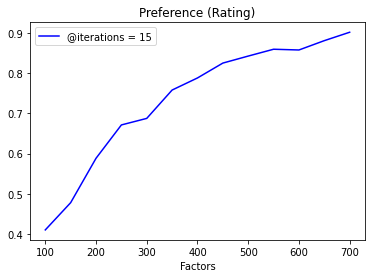

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# training result
plt.figure(figsize=(6, 4))

plt.plot(factors_plt, preference_plt, 'b-', label='@iterations = 20')
plt.xlabel('Factors')

#plt.xticks([0, 1, 2])
#plt.yticks(np.arange(0, 7))

plt.title('Preference (Rating)')
plt.legend()

plt.show()

In [38]:
# factors값의 변화에 따른 preference값 변화 시각화를 위한 리스트 값 초기화
factors_plt = []
preference_plt = []

In [39]:
# iterations = 20으로 고정하고 최적 factors값 찾기: 660부터 1000까지 20 간격으로 모델 훈련 및 결과값 확인

for factors in range(660, 1001, 20):
    #모델 설정
    als_model = AlternatingLeastSquares(factors, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)
    #모델 실행
    als_model.fit(csr_data_transpose)
    #preference 결과값 계산
    me, goodmen = user_to_idx['me'], movie_to_idx['few good men, a (1992)']
    me_vector, goodmen_vector = als_model.user_factors[me], als_model.item_factors[goodmen]
    goodmen_rate = np.dot(me_vector, goodmen_vector)
    #결과값 시각화를 위해 값 저장
    factors_plt.append(factors)
    preference_plt.append(goodmen_rate)
    #결과값 확인
    print("🐯 factors:", factors, "    💖 preference:", goodmen_rate)

  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 660     💖 preference: 0.8992176


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 680     💖 preference: 0.9025764


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 700     💖 preference: 0.90406257


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 720     💖 preference: 0.91241187


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 740     💖 preference: 0.9032974


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 760     💖 preference: 0.91379774


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 780     💖 preference: 0.91790205


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 800     💖 preference: 0.91807187


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 820     💖 preference: 0.9210503


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 840     💖 preference: 0.9300234


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 860     💖 preference: 0.9277352


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 880     💖 preference: 0.93072987


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 900     💖 preference: 0.9436888


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 920     💖 preference: 0.93358725


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 940     💖 preference: 0.95338184


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 960     💖 preference: 0.9489526


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 980     💖 preference: 0.93907255


  0%|          | 0/20 [00:00<?, ?it/s]

🐯 factors: 1000     💖 preference: 0.9477472


In [40]:
print("🐯 factors:", factors_plt)
print("💖 preference:", preference_plt)

🐯 factors: [660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000]
💖 preference: [0.8992176, 0.9025764, 0.90406257, 0.91241187, 0.9032974, 0.91379774, 0.91790205, 0.91807187, 0.9210503, 0.9300234, 0.9277352, 0.93072987, 0.9436888, 0.93358725, 0.95338184, 0.9489526, 0.93907255, 0.9477472]


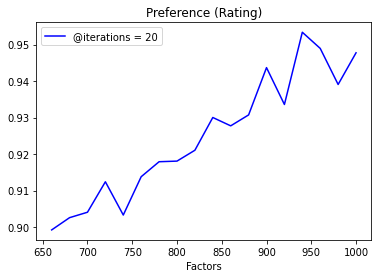

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# training result
plt.figure(figsize=(6, 4))

plt.plot(factors_plt, preference_plt, 'b-', label='@iterations = 20')
plt.xlabel('Factors')

#plt.xticks([0, 1, 2])
#plt.yticks(np.arange(0, 7))

plt.title('Preference (Rating)')
plt.legend()

plt.show()

### ※ factors, iterations에 대한 최적값(?) 찾기 
  - factors값을 크게 할수록 선호도 1에 가까워짐
  - iterations값은 선호도에 큰 영향을 미치지 않음
  - factors값을 높일수록 선호도가 올라가나 과적합이 우려되므로 **factors=840, 선호도 93% 수준의 모델**을 사용하여 예측 실행

- **factors=100, <span style="color:blue">iterations=20 ⇒ 0.39486203: iterations = 20 사용</span>**  
  
   
- **<span style="color:blue">factors=840</span>, iterations=20 <span style="color:blue">⇒ 0.9300234 이 모델을 사용하여 예측 실행</span>**


### 6) 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라  훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [43]:
c_tide = movie_to_idx['crimson tide (1995)']
c_tide_vector = als_model.item_factors[c_tide]
np.dot(me_vector, c_tide_vector)

0.9120291

- <span style="color:blue; font-weight:bold; font-size:15px"> 선호하는 영화: crimson tide (1995)에 대한 선호도 예측</span>
  - <span style="color:blue; font-weight:bold; font-size:15px"> 0.91로 아주 높게 나옴</span>

In [44]:
rainman = movie_to_idx['rain man (1988)']
rainman_vector = als_model.item_factors[rainman]
np.dot(me_vector, rainman_vector)

0.02664613

- <span style="color:blue; font-weight:bold; font-size:15px"> 그 외의 영화 rain man (1988)에 대한 선호도 예측</span>
  - <span style="color:blue; font-weight:bold; font-size:15px"> 0.03으로 낮게 나옴</span>
- <span style="color:blue; font-weight:bold; font-size:15px">선호하는 영화: 미션 임파서블(톰크루즈), 어퓨굿맨(톰크루즈), 크림슨타이드(덴젤워싱톤), 탑건(톰크루즈), 쇼생크탈출</span>
- <span style="color:blue; font-weight:bold; font-size:15px">'rain man (1988)'은 위 다섯 편의 영화 중 세 편과 주연 배우(탐 크루즈)는 같으나 내용(주제)이 다르기 때문에 낮은 점수가 나온 것으로 추측되며</span>
- <span style="color:blue; font-weight:bold; font-size:15px">따라서 모델이 추천을 잘하고 있다고 볼 수 있음</span>

### 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

- 내가 좋아하는 few good men, a (1992)와 비슷한 영화 찾기 (10개)
  - AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드 사용

In [45]:
favorite_movie = 'few good men, a (1992)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=10)
similar_movie

[(59, 1.0),
 (3565, 0.47423613),
 (3422, 0.4722798),
 (3374, 0.47119808),
 (3308, 0.47097015),
 (3408, 0.47019216),
 (3406, 0.4700407),
 (3410, 0.46992466),
 (3409, 0.46987084),
 (3288, 0.4697708)]

- **(영화_id, 유사도)** Tuple로 반환
  - 유사도: 0.5 정도
- 영화_id를 다시 영화 이름으로 매핑

In [46]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['few good men, a (1992)',
 'anna (1996)',
 'country life (1994)',
 'peanuts - die bank zahlt alles (1996)',
 'tigrero: a film that was never made (1994)',
 'resurrection man (1998)',
 "wooden man's bride, the (wu kui) (1994)",
 'foolish (1999)',
 'tainted (1998)',
 'hatchet for the honeymoon (rosso segno della follia) (1969)']

- Anna (1996) - IMDbhttps://www.imdb.com › title
The film tells of faithful devotion to spiritual ideals. It is based on Riga St. Anna Stocken's Life Story of the Cistercian Monastery of Mary Magdalene.
- Country Life (1994) - IMDbhttps://www.imdb.com › title
Adaptation of Chekhov's "Uncle Vanya" set in rural Australia in the 1920's. Jack Dickens and his niece Sally run the family farm to support brother-in-law.
- Peanuts - Die Bank zahlt alles (1996) - IMDbhttps://www.imdb.com › title
The movie is based on the real life real-estate business man Jürgen Schneider, who invested in various buildings around Germany and got bankrupt.
- Tigrero: A Film That Was Never Made (1994) - IMDbhttps://www.imdb.com › title
In 1993, Sam Fuller takes Jim Jarmusch on a trip into Brazil's Mato Grosso, up the River Araguaia to the village of Santa Isabel Do Morro, where 40 years ...
- Resurrection Man (1998) - IMDbhttps://www.imdb.com › title
Belfast, in 1970s. Victor Kelly is a young protestant man who hates the Catholics so much that one night he begins to brutally murder them.
- The Wooden Man's Bride (1994) - IMDbhttps://www.imdb.com › title
The main character, Wu Kui, is a hired hand who is sent to bring the bride back to her future rich husband's house. On the way he displays a mischievous side by ...
- Foolish (1999) - IMDbhttps://www.imdb.com › title
Foolish is a decent flick , based on where it came from. Eddie Griffin does what he can with the script, but it almost takes away from his acting chops. 
- Tainted (1998) - IMDbhttps://www.imdb.com › title
A sarcastic comedy thriller about a vampire who sets out to infect the blood of a hospital and the twenty-something slackers who set out to stop him.
- Hatchet for the Honeymoon (1970) - IMDbhttps://www.imdb.com › title
Hatchet for the Honeymoon: Directed by Mario Bava. With Stephen Forsyth, Dagmar Lassander, ... Stephen Forsyth in Il rosso segno della follia (1970).  
  
  
- <span style="color:blue; font-size:15px"> 전부 모르는 영화임 ㅎㅎ</span>


- 위의 코드를 함수로 생성

In [47]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

print("슝=3")

슝=3


- 'rain man (1988)'로도 확인

In [48]:
get_similar_movie('rain man (1988)')

['rain man (1988)',
 'cabinet of dr. ramirez, the (1991)',
 'prom night iii: the last kiss (1989)',
 'snowriders (1996)',
 'horror express (1972)',
 'bittersweet motel (2000)',
 'bushwhacked (1995)',
 'napoleon and samantha (1972)',
 'mirage (1995)',
 'amityville 3-d (1983)']

- 'mission: impossible (1996)'로도 확인

In [49]:
get_similar_movie('mission: impossible (1996)')

['mission: impossible (1996)',
 'diamonds (1999)',
 'montana (1998)',
 "brown's requiem (1998)",
 'secret agent, the (1996)',
 'full speed (1996)',
 'one little indian (1973)',
 'grandview, u.s.a. (1984)',
 "where's marlowe? (1999)",
 'beautiful (2000)']

### 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

- AlternatingLeastSquares 클래스에 구현되어 있는 **recommend 메서드**를 통하여 제가 좋아할 만한 아티스트를 추천받습니다. 
- **filter_already_liked_items** 는 유저가 이미 평가한 아이템은 제외하는 Argument입니다.

In [50]:
user = user_to_idx['me']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(1547, 0.09781727),
 (56, 0.08641157),
 (751, 0.07793154),
 (188, 0.070922),
 (419, 0.068423085),
 (1358, 0.06668249),
 (1626, 0.06652028),
 (1764, 0.064453654),
 (447, 0.064264566),
 (541, 0.06364648),
 (978, 0.063607305),
 (1219, 0.06304938),
 (1866, 0.06039811),
 (1241, 0.0603254),
 (2398, 0.059137467),
 (1182, 0.05810144),
 (452, 0.05632773),
 (2075, 0.056167945),
 (778, 0.055022947),
 (1243, 0.054532647)]

In [51]:
[idx_to_movie[i[0]] for i in movie_recommended]

['fly ii, the (1989)',
 'courage under fire (1996)',
 'swing kids (1993)',
 'indiana jones and the temple of doom (1984)',
 'jfk (1991)',
 'birds, the (1963)',
 'titanic (1953)',
 "nobody's fool (1994)",
 'adventures of priscilla, queen of the desert, the (1994)',
 'all quiet on the western front (1930)',
 'hot shots! part deux (1993)',
 'first blood (1982)',
 'trip to bountiful, the (1985)',
 'flamingo kid, the (1984)',
 'tigerland (2000)',
 'red dawn (1984)',
 'cruel intentions (1999)',
 'i love trouble (1994)',
 'conan the barbarian (1982)',
 'flashdance (1983)']

- 'fly ii, the (1989)',
  - 플라이 2, 1989년 ‧ SF/공포 ‧ 1시간 45분: 《플라이 2》는 미국에서 제작된 크리스 월러스 감독의 1989년 공포, SF 영화이다. 에릭 스톨츠 등이 주연으로 출연하였고 스티븐-찰스 자프 등이 제작에 참여하였다. 1986년 영화 플라이의 후속작이다
-  'courage under fire (1996)',
  - 커리지 언더 파이어 (Courage Under Fire): 《커리지 언더 파이어》는 1996년 공개된 미국의 전쟁 영화이다. 에드워드 즈윅이 감독을 맡았으며, **덴절 워싱턴**과 메그 라이언이 출연한다. 덴절 워싱턴과 에드워드 즈윅의 두번째 합작 작품이다. 영화는 미국에서 1996년 7월 12일 공개되었다.
- 'swing kids (1993)',
- 'indiana jones and the temple of doom (1984)',
- 'jfk (1991)',
- 'birds, the (1963)',
- 'titanic (1953)',
- 'nobody's fool (1994)',
- 'adventures of priscilla, queen of the desert, the (1994)',
- 'all quiet on the western front (1930)',
- 'hot shots! part deux (1993)',
- 'first blood (1982)',
- 'trip to bountiful, the (1985)',
- 'flamingo kid, the (1984)',
- 'tigerland (2000)',
- 'red dawn (1984)',
- 'cruel intentions (1999)',
- 'i love trouble (1994)',
- 'conan the barbarian (1982)',
- 'flashdance (1983)']
  
  
- <span style="color:blue">모델은 왜 courage under fire (1996)를 추천해 줬을까요?</span> 
  - AlternatingLeastSquares 클래스에 구현된 **explain 메서드**를 사용하면 제가 기록을 남긴 데이터 중 **이 추천에 기여한 정도를 확인**할 수 있습니다.

In [56]:
c_u_f = movie_to_idx['courage under fire (1996)']
explain = als_model.explain(user, csr_data, itemid=c_u_f)

- 이 method는 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠의 기여도(합이 콘텐츠의 점수가 됩니다)를 반환합니다. 어떤 영화들이 이 추천에 얼마나 기여하고 있는 걸까요?

In [57]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('crimson tide (1995)', 0.06124669131438029),
 ('top gun (1986)', 0.026595772905246635),
 ('few good men, a (1992)', -0.0010712882747334622),
 ('mission: impossible (1996)', -0.0012176312039766453),
 ('shawshank redemption, the (1994)', -0.0013492977952143182)]

- **추천 영화: courage under fire (1996)**
  - 《커리지 언더 파이어》는 1996년 공개된 미국의 **전쟁 영화**이다. 
  - 에드워드 즈윅이 감독을 맡았으며, **덴절 워싱턴**과 메그 라이언이 출연한다. 
  - 공군 조종사와 관련된 스토리라고 함
    - 덴절 워싱턴: 너새니얼 설링 중령
    - 메그 라이언: UH-1 휴이 **조종사** 캐런 에마 월든 대위

- 위 결과를 보면 'crimson tide (1995)', 0.061)와 ('top gun (1986)', 0.027)이 영향을 주었음을 알 수 있음
  - **크림슨타이드**: **덴젤 워싱턴** 주연, 잠수함에서 **핵공격** 여부 결정을 두고 벌어지는 함장과 부함장(덴젤 워싱턴)의 갈등 스토리
  - **탑건**: 톰 크루즈 주연. **조종사**들의 비행 훈련과 관련된 스토리
  
  
- **<span style="color:blue">덴젤 워싱톤, 공군, 전쟁 등의 공통점이 있음</span>**

# 프로젝트 평가

| 평가문항 | 상세기준 | 실행 결과 |
|:---|:---|:---| 
| 1. CSR matrix가 정상적으로 만들어졌다. | 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다. | 정확히 만들어졌음. 4)항 참고.<br> <6040x3628 sparse matrix of type '<class 'numpy.int64'>' with 836483 stored elements in Compressed Sparse Row format> |
| 2. MF 모델이 정상적으로 훈련되어 그럴듯한  추천이 이루어졌다. | 사용자와 아이템 벡터 내적수치가 의미있게  형성되었다. | 의미있게 형성됨. 6)항 참고. <br> 선호하는 영화: crimson tide (1995)에 대한 선호도 예측 0.91로 아주 높게 나옴 |
| 3. 비슷한 영화 찾기와 유저에게 추천하기의  과정이 정상적으로 진행되었다. | MF모델이 예측한 유저 선호도 및 아이템간  유사도, 기여도가 의미있게 측정되었다. | 의미있게 측정됨. 8)항 참고. <br> 《crimson tide (1995), 기여도 0.061》와 《top gun (1986), 기여도 0.027》이 영향을 주어 《커리지 언더 파이어 (1996), 0.086》 추천됨 |

## 회고

- 모델 훈련시 선호도(정확도)값만 나옴
  - 다른 모델들에서는 training accuracy와 validation accuracy를 비교해서 과대적합을 피할 수 있었으나<br>
    프로젝트에서 사용한 als (Alternating Least Suares) 모델에서는 어떻게 할 수 있는지???
- 추천 결과를 보면 적은 데이터로 학습을 시켰음에도 불구하고 추천이 잘 이루어지는 것 같음
- 실제 사용하기 위해서는 많은 보완(데이터 특성 항목 및 데이터 수 확대, 정교한 모델의 선택 등) 이 필요하겠음
  